# Classification of image using CNN
The CIFAR-10 dataset is a widely-used benchmark dataset in machine learning, particularly in the field of image classification. It consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 test images. The 10 classes represent different object categories such as airplanes, cars, birds, cats, and more.
The outcome of this project is a CNN model that can classify images in the CIFAR-10 dataset with a certain level of accuracyThe model's performance is evaluated using standard metrics


Importing necessary labraries  

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

Loading CIFAR-10 Dataset

In [ ]:
(trn_img, trn_label), (test_img, test_label) = datasets.cifar10.load_data()

Split original training data to training and validation sets

In [ ]:
 trn_img, test_img, trn_label, test_label = train_test_split(trn_img, trn_label, test_size=0.2, random_state=0)

Normalisation of pixel value

In [ ]:
trn_img = trn_img/255
test_img = test_img/255

Defining class name for CIFAR-10 Dataset

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Visualizing sample images of CIFAR-10 dataset

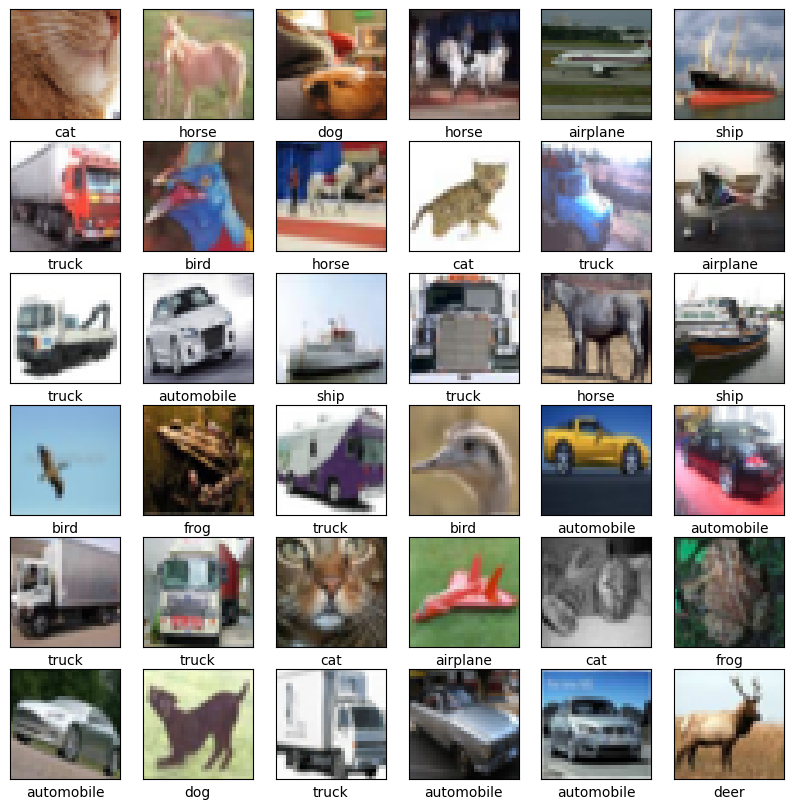

In [ ]:
plt.figure(figsize=(10,10))
for i in range(36):
  plt.subplot(6,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(trn_img[i],cmap=plt.cm.binary)
  plt.xlabel(class_names[trn_label[i][0]])
plt.show()


Building CNN model

In [ ]:
def build_model(hp):
  model = models.Sequential()

  # Tune the number of Convolutional Layers (1, 2 or 3)
  for i in range(hp.Int('conv_layers', 1, 3)):
    if i == 0:
      model.add(layers.Conv2D(
        filters = hp.Int('filters_' + str(i), min_value=32, max_value=128, step=16),
        kernel_size = (3, 3),
        activation = 'relu',
        input_shape = (32, 32, 3)
      ))
  else:
    model.add(layers.Conv2D(
      filters = hp.Int('filters_' + str(i), min_value=32, max_value=128, step=16),
      kernel_size = (3, 3),
      activation = 'relu',
      padding = 'same'))

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())

  # Tune the number of Dense Layers (1,2 or 3)
  for i in range(hp.Int('dense_layers', 1, 3)):
    model.add(layers.Dense(
      units = hp.Int('units_' + str(i), min_value=32, max_value=128, step=16),
      activation = 'relu'))

  # Tune the dropout rate
  model.add(layers.Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

  # The last dense layer with 10 output units (for 10 classes of CIFAR-10 dataset)
  model.add(layers.Dense(10))

# Choose an optimizer and learning rate
  optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
  model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  return model


In [ ]:
!pip install keras-tuner
from keras_tuner import RandomSearch
tuner = RandomSearch(
  build_model,
  objective='val_accuracy',
  max_trials=10,
  executions_per_trial=1,
  directory='my_dir',
  project_name='cifar10_tunning'
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
tuner.search(trn_img, trn_label, epochs=5, validation_data=(test_img, test_label))

Trial 10 Complete [00h 00m 53s]
val_accuracy: 0.666700005531311

Best val_accuracy So Far: 0.6723999977111816
Total elapsed time: 00h 08m 48s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)

Printing moodel summary

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 30, 30, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         921,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 946,442 (3.61 MB)

 Trainable params: 946,442 (3.61 MB)

 Non-trainable params: 0 (0.00 B)

Evaluating performance of the Model

In [ ]:
history = model.fit(trn_img,trn_label, epochs=15, validation_data=(test_img,test_label))

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.3712 - loss: 1.7194 - val_accuracy: 0.5414 - val_loss: 1.2690
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5961 - loss: 1.1450 - val_accuracy: 0.6268 - val_loss: 1.0494
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6748 - loss: 0.9241 - val_accuracy: 0.6445 - val_loss: 1.0112
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7282 - loss: 0.7706 - val_accuracy: 0.6571 - val_loss: 0.9834
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7761 - loss: 0.6454 - val_accuracy: 0.6605 - val_loss: 1.0347
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8141 - loss: 0.5290 - val_accuracy: 0.6566 - val_loss: 1.0937
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8530 - loss: 0.4233 - val_accuracy: 0.6601 - val_loss: 1.2295
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8830 - loss: 0.3344

In [ ]:
test_loss,test_acc = model.evaluate(test_img, test_label,verbose=2)
print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 - 1s - 2ms/step - accuracy: 0.6297 - loss: 2.4517

Test Accuracy: 0.6297000050544739
Test Loss:     2.4517059326171875


Generate plots for visualizing the training loss, and accuracy evolution over epochs using model history:

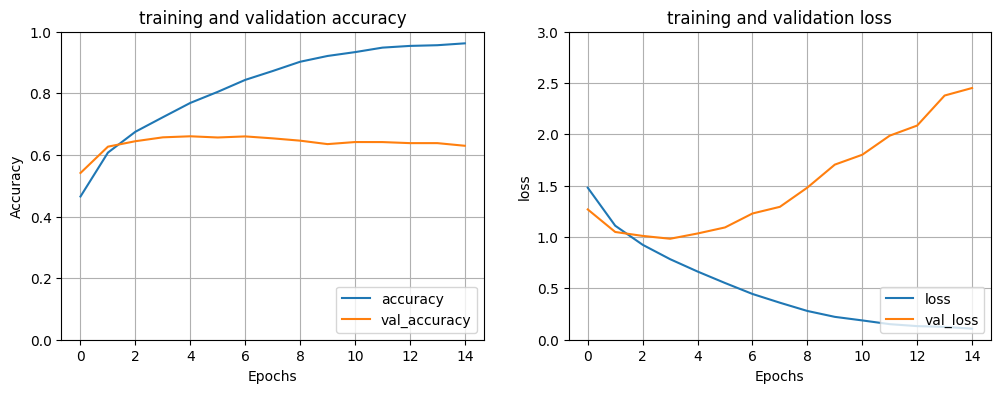

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend(loc = 'lower right')
plt.title('training and validation accuracy')
plt.grid()


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.ylim(0,3)
plt.legend(loc = 'lower right')
plt.title('training and validation loss')
plt.grid()

plt.show()